# N-uncial Proyection: Numerical Implementation

El propósito de este documento es presentar la implementación numérica del artículo "Inverses and n-uncial property of Jacobian elliptic functions" (Solanilla, Leal, Tique, 2021) utilizando el lenguaje de programación Python. Este trabajo se centra en la creación de mapas del planeta Tierra mediante las proyecciones n-unciales, las cuales son obtenidas a partir de la generalización de la propiedad de quincuncialidad presente en la inversa de función elíptica de Jacobi $c_{n}$, relacionada con la proyección quincuncial de Peirce (Solanilla, Oostra, Yáñez, 2016). A saber, se demostró que todas las inversas de las funciones elípticas de Jacobi son n-unciales.

Para lograr la implementación numérica se emplea el archivo "toolbox.py" que proporciona el código necesario para generar coordenadas esféricas de los meridianos, paralelos y paises; mapear la proyección estereográfica y visualizar cada etapa del proceso.

Cada proyección n-uncial es la composición de la proyección estereográfica con la inversa de una función eliptica de Jacobi. En ese sentido, este cuaderno está dividido en tres secciones:

**1.** En la primera, se importa el archivo "toolbox.py" para ser usado en las siguientes secciones. Además se cargan los datos geoespaciales de tierra firme y se obtienen sus coordenadas esféricas.

**2.** Se realiza la primera composicion mapeando las coordenadas iniciales con la proyección estereográfica.

**3.** Se transforman las coordenas estereograficas usando cada inversa de las funciones elipticas de Jacobi con modulo $\frac{1}{\sqrt{2}}$, para ser graficadas posteriormente. Como resultado, el mapamundi segun la respectiva proyección n-uncial.


## 1. Importe de archivos y generación de coordenadas esfericas

In [1]:
from Functions.toolbox import *

A continuación se genera una cantidad específica de puntos (num_puntos) distribuidos sobre cada país y se grafica en la esfera terrestre. Ya que el número de puntos a gráficar sobre cada país es el mismo, en los paises más pequeños habrá mayor concentración de puntos que en los paises grandes. Luego se grafica la esfera terrestre con las coordenadas generadas.

In [2]:
meridianos = generar_meridianos(37, 200) #(numero_de_meridianos, numero_de_puntos_por_meridiano)
paralelos = generar_paralelos(37, 200) # funciones guardadas en toolbox.py

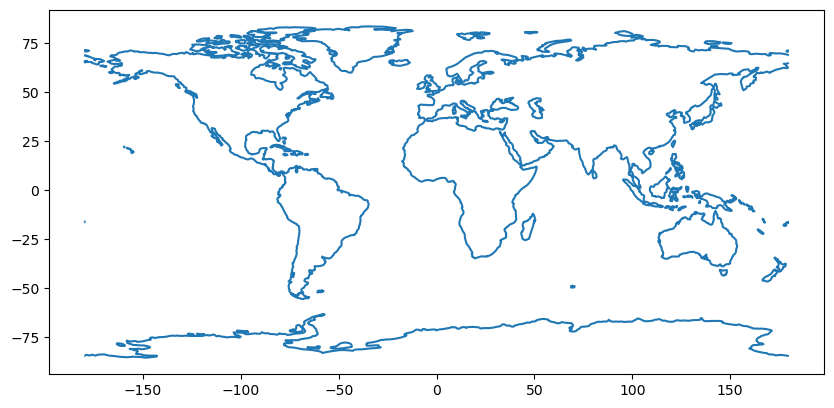

In [3]:
# CARGAR DATOS

# Ruta al archivo shapefile
ruta = "data/ne_110m_coastline/ne_110m_coastline.shp"

# Cargando el shapefile en un DataFrame de GeoPandas
gdf = gpd.read_file(ruta)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 10))

# Graficar la capa del shapefile
gdf.plot(ax=ax)

# Mostrar el gráfico
plt.show()

In [6]:
import pandas as pd
import numpy as np
from math import radians

# CONVETIR A RADIANES

# Crear un nuevo DataFrame
nuevo_df = pd.DataFrame(columns=['coordenadas'])

# Iterar sobre cada fila del DataFrame original
for index, row in gdf.iterrows():
    # Obtener las coordenadas del LINESTRING y convertirlas a radianes
    coordenadas = [(radians(lon)+np.pi, radians(lat)+np.pi/2) for lon, lat in row['geometry'].coords]
    # Agregar las coordenadas al nuevo DataFrame
    nuevo_df.loc[index] = [coordenadas]
# Extraer la columna 'coordenadas' como lista de parejas ordenadas
lista_radianes = nuevo_df['coordenadas'].tolist()




# ROTAR LOS DATOS Y HACER LO MISMO
def rotate_spherical_points(theta, phi):
    # Convert to Cartesian coordinates
    r = 1  # Assuming unit sphere
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    
    # Apply the rotation (180 degrees around the x-axis)
    x_rot = x
    y_rot = -y
    z_rot = -z
    
    # Convert back to spherical coordinates
    r_rot = np.sqrt(x_rot**2 + y_rot**2 + z_rot**2)
    phi_rot = np.arccos(z_rot / r_rot)
    theta_rot = np.arctan2(y_rot, x_rot)
    
    return theta_rot, phi_rot

# Crear un nuevo DataFrame para almacenar las coordenadas rotadas
nuevo_df_rotado = pd.DataFrame(columns=['coordenadas_rotadas'])

# Iterar sobre cada fila del nuevo DataFrame
for index, row in nuevo_df.iterrows():
    # Obtener las coordenadas en radianes
    coordenadas = row['coordenadas']
    
    # Rotar cada par de coordenadas (theta, phi)
    coordenadas_rotadas = [rotate_spherical_points(theta, phi) for theta, phi in coordenadas if phi>np.pi/2]

    # Agregar las coordenadas rotadas al nuevo DataFrame
    nuevo_df_rotado.loc[index] = [coordenadas_rotadas]

# Extraer la columna 'coordenadas_rotadas' como lista de parejas ordenadas
lista_rotada = nuevo_df_rotado['coordenadas_rotadas'].tolist()

## 2. Proyección estereográfica
En esta sección se transforman las coordenadas antes generadas mediante la proyección estereográfica.

In [63]:
def estereografica(punto):
    theta = -punto[0]
    p = -punto[1]
    z = np.tan(p/ 2) * np.exp(1j * theta)
    return (np.real(z), np.imag(z))

In [64]:
# EXTRAER DATOS DE CADA HEMISFERIO POR SEPARADO
lista_sur=[]
for lista in lista_radianes:
    ls=[]
    for punto in lista:
        if punto[1] < np.pi/2:
            ls.append(punto)
    lista_sur.append(ls) 


lista_norte=[]
for lista in lista_rotada:
    ls=[]
    for punto in lista:
        if punto[1] < np.pi/2:
            ls.append(punto)
    lista_norte.append(ls) 

In [65]:
# EXTRAER DATOS DE CADA HEMISFERIO POR SEPARADO Y CONVERTIR A COORDENADAS ESTEREOGRÁFICAS
lista_estereograficas_sur=[]
for lista in lista_radianes:
    ls=[]
    for punto in lista:
        if punto[1] < np.pi/2:
            ls.append(estereografica(punto))
    lista_estereograficas_sur.append(ls) 

lista_estereograficas_norte=[]
for lista in lista_rotada:
    ls=[]
    for punto in lista:
        if punto[1] < np.pi/2:
            ls.append(estereografica(punto))
    lista_estereograficas_norte.append(ls) 

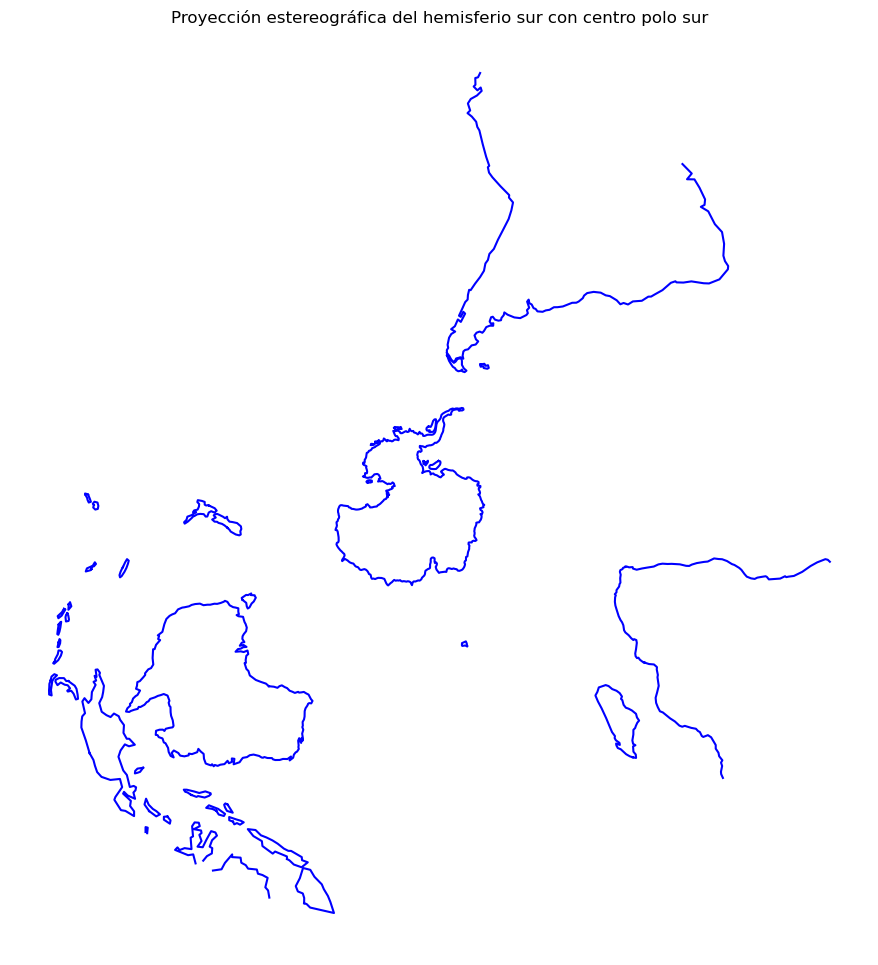

In [66]:
plot_proyeccion(lista_sur, estereografica, "Proyección estereográfica del hemisferio sur con centro polo sur")

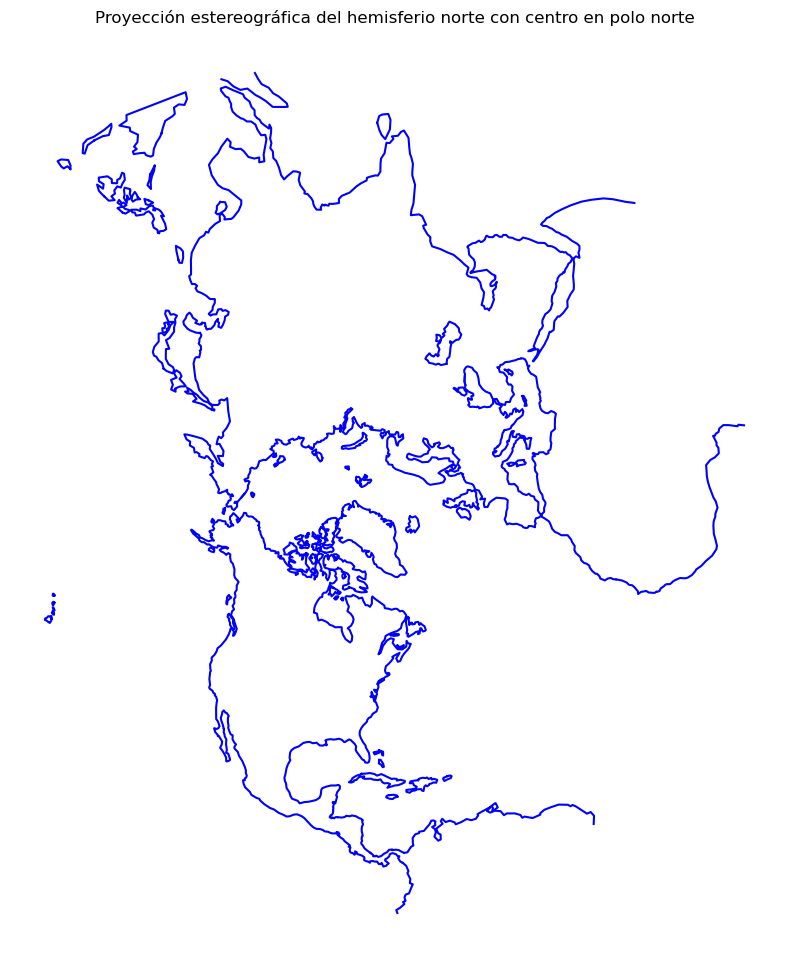

In [67]:
plot_proyeccion(lista_norte, estereografica, "Proyección estereográfica del hemisferio norte con centro en polo norte")

## 3. Proyecciones N-unciales

En esta sección se define cada una de las inversas de las funciones elipticas de Jacobi y se aplican a las coordenadas estereográficas de la sección 2 con el fin de visualizar los mapas de la tierra producidos por cada una de ellas.

### 3.1 $cn^{-1}z= F(arc cos z)$ (Proyección quincuncial)

In [68]:
def cni(punto):
    a=punto[0]
    b=punto[1]
   
    x=ellipf(np.arccos(a), 0.5)
    y=ellipf(np.arccos(b), 0.5)
    return (x, y)

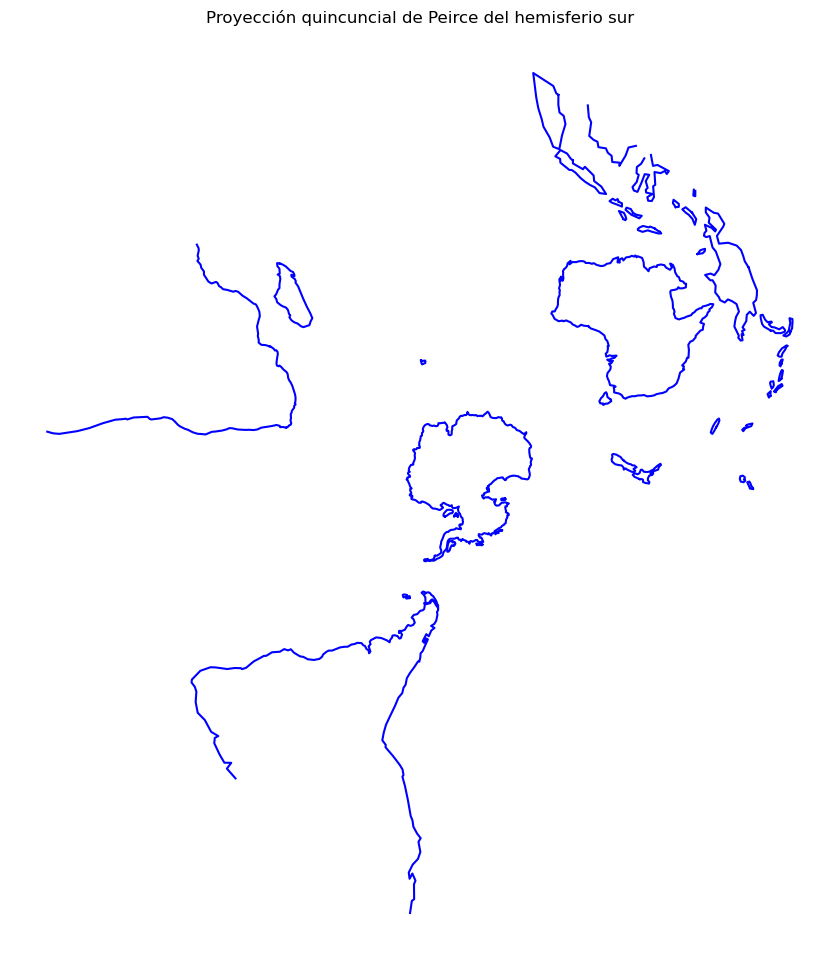

In [69]:
plot_proyeccion(lista_estereograficas_sur, cni, "Proyección quincuncial de Peirce del hemisferio sur")

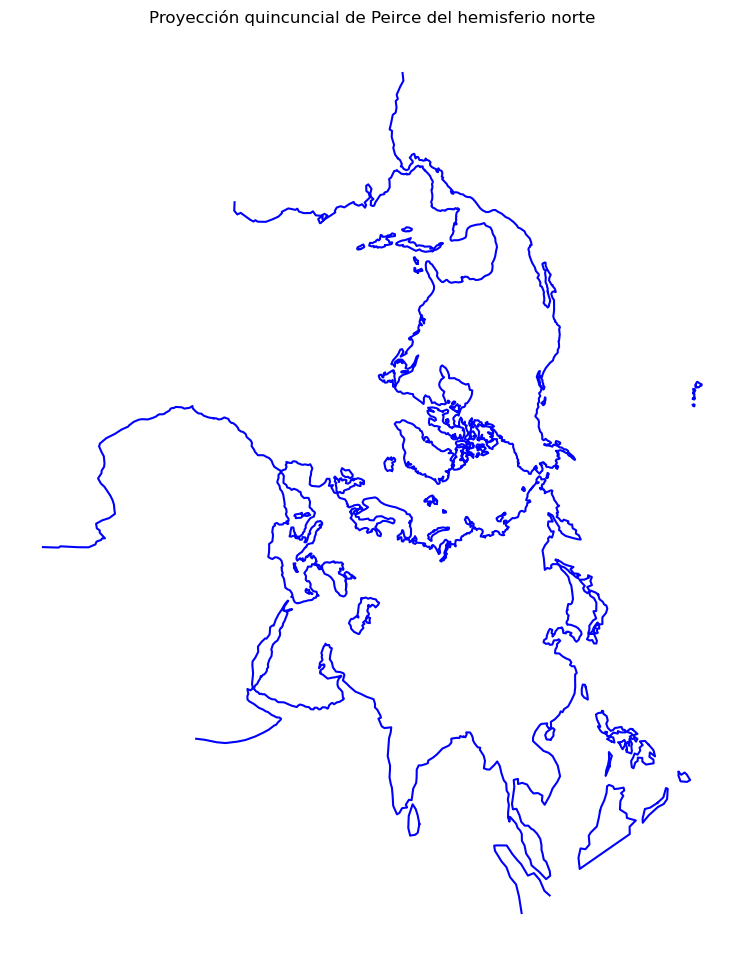

In [70]:
plot_proyeccion(lista_estereograficas_norte, cni, "Proyección quincuncial de Peirce del hemisferio norte")

### 3.2 cd

In [71]:
def cdi(punto):
    a=punto[0]
    b=punto[1]
    k=1/np.sqrt(2)
    x=ellipf(np.arcsin(np.sqrt((1-(a**2))/(1-(k**2)*(a**2)))), 0.5)
    y=ellipf(np.arcsin(np.sqrt((1-(b**2))/(1-(k**2)*(b**2)))), 0.5)
    return (x,y)

cni((1/np.sqrt(2)+0.00001,-1))

(mpf('0.82600154624064492'), mpf('3.7081493546027438'))

**NOTA.** Tanto la inversa de cd como la invesa de cn tienen, en su caracterización en la Tabla 8 (art. 2021), dominio el intervalo real [-1,1]. Esto permite visualizar que pasa en la situación actual (en las otras, ni se diga). Necesito entender los dominios básicos de estas funciones para poder dividirlos correctamente en dos y hacer las funciones inyectivas. Ver gráfico a continuación:

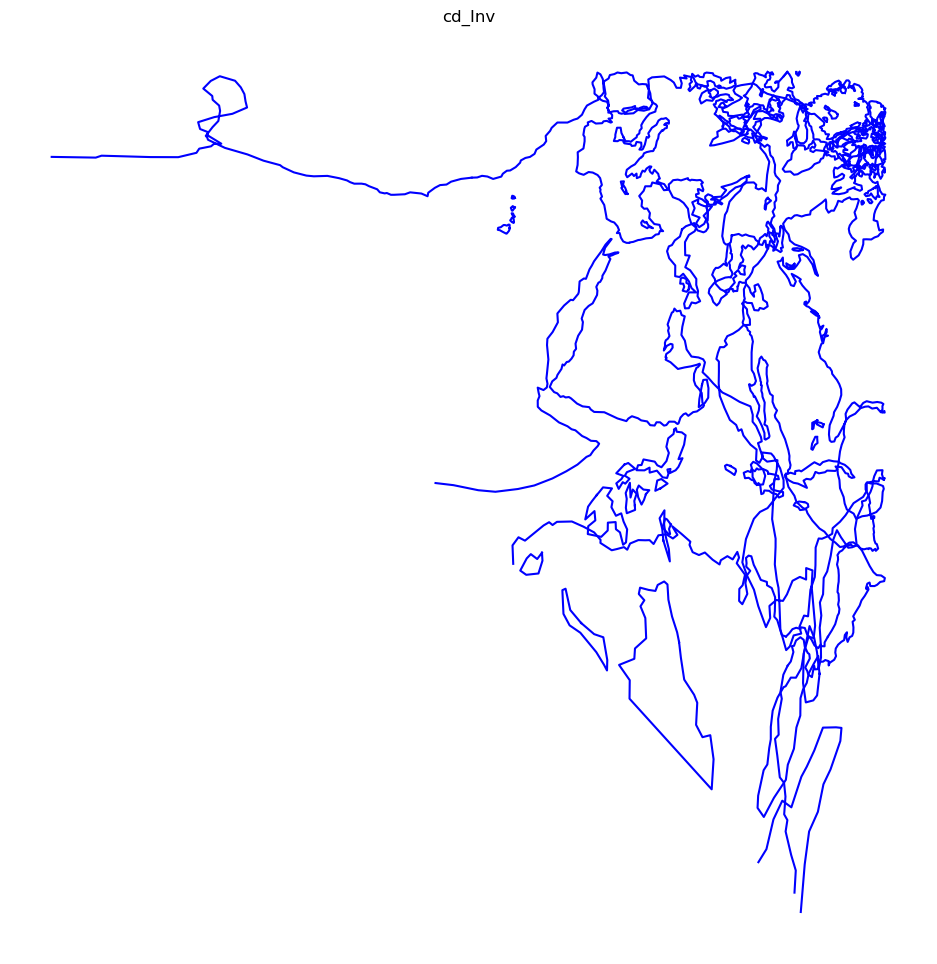

In [74]:
plot_proyeccion(lista_estereograficas_norte, cdi, "cd_Inv")

Se distinguen los continentes uno sobre el otro.